In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import datascience as ds
import numpy as np
from sklearn.metrics import r2_score
from sklearn import preprocessing
# import scipy.stats

features_list = ["wind_10m", "specific_humidity", "LW_down", "SW_down", "rainfall", "snowfall", "sosaline", "sst", "t2m", "surface_pressure", "sea_ice_extent"]

# Feature Trends Inquiry and Analysis

The dataset was found [here](https://github.com/big-data-lab-umbc/sea-ice-prediction) and the screenshot of feature significance came from an article found [here](https://s3.us-east-1.amazonaws.com/climate-change-ai/papers/icml2021/50/paper.pdf).

**MLA citation:** `Ali, Sahara, et al. "Sea Ice Forecasting using Attention-based Ensemble LSTM." arXiv preprint arXiv:2108.00853 (2021).`

## Data visualization

**Objective:** Pinpoint trends in Ice Extent feature data and explain their nature

### 1 Pre-analysis preperation

- Organize data, declare relevant variables
- Condense average yearly data into one row per year

In [5]:
full_data = ds.Table().read_table("ArcticDataset.csv")
full_data_avg = ds.Table(["year"] + features_list)

for year in range(min(full_data.column("Year")), max(full_data.column("Year")) + 1):
    averages_array = []
    for feature in features_list:
        averages_array.append(sum(full_data.where("Year", ds.are.equal_to(year)).column(feature)) / len(full_data.where("Year", ds.are.equal_to(year)).column(feature)))
    full_data_avg = full_data_avg.with_row([year] + averages_array)
    averages_array = []
full_data_avg.show(4)
# full_data_avg.to_csv("ArticYearlyMeanDataset.csv")

C:\Users\Louis Lapp\AppData\Local\Temp\ipykernel_19492\2453225884.py:7: RuntimeWarning: overflow encountered in long_scalars
  averages_array.append(sum(full_data.where("Year", ds.are.equal_to(year)).column(feature)) / len(full_data.where("Year", ds.are.equal_to(year)).column(feature)))


year,wind_10m,specific_humidity,LW_down,SW_down,rainfall,snowfall,sosaline,sst,t2m,surface_pressure,sea_ice_extent
1979,5.07764,2.21866,237.497,96.3341,1.34656,0.70885,33.2524,274.36,263.532,981.987,558760
1980,5.12035,2.24572,239.288,96.7265,1.28481,0.695901,33.2624,274.489,264.163,982.866,599279
1981,5.18837,2.30067,243.107,96.0786,1.39369,0.760159,33.246,274.363,264.963,981.639,362687
1982,5.1452,2.19611,237.621,97.6215,1.36295,0.738999,33.2725,274.287,263.673,981.126,677983


### 2 Graph trends

- Graph line plots of each feature
- Graph trendlines

In [7]:
for feature in features_list:
    full_data_avg.plot("year", feature)
    x = full_data_avg.column("year")
    y = full_data_avg.column(feature)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.title("y=" + str(round(z[0], 6)) + "x + " + str(round(z[1], 6)))
    plt.savefig("feature_graphs_min0/" + feature + ".png")

## Multivariate Arctic Feature Analysis

**Objective:** Visualize features, identify trends, and establish correlation between multiple variables 

### 1 Visualize data

Create plot for every variable pair

In [ ]:
# R (do not run)
full_data <- read.csv("C:\\Users\\Louis Lapp\\Documents\\Research\\MultivariableArcticFeature_Analysis\\ArticYearlyMeanDataset.csv")
png(filename = "Multivariable_Plot.png", width = 1000, height = 1000)
plot(full_data)
dev.off()

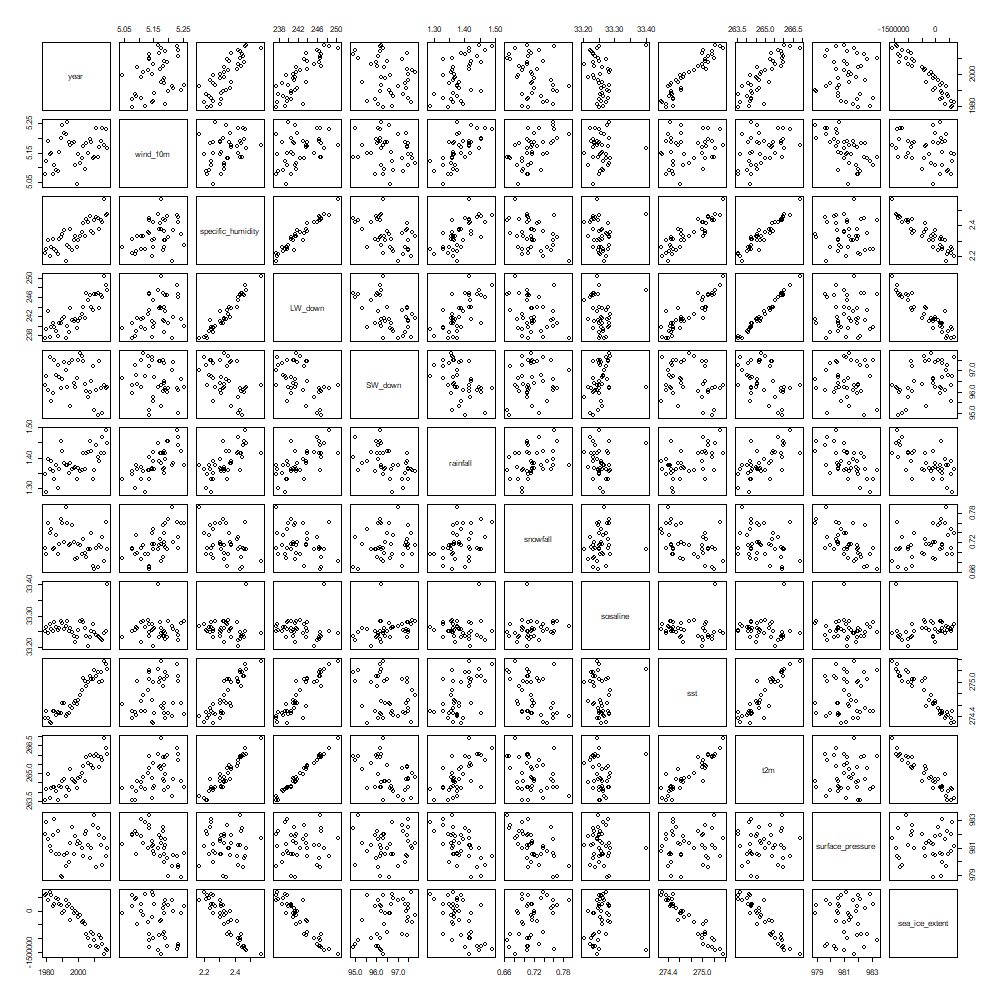

In [3]:
Image(filename='Multivariable_Plot.png') 

### 2 Determine correlations

Create table with relevant correlation information

**Note:** An improved version of the table below was coded in R; that table will be used in place of the one generated below

In [2]:
full_data_avg = ds.Table().read_table("ArticYearlyMeanDataset.csv")
correlation_table = ds.Table(["X", "Y", "r_squared", "m", "b"])
for feature in features_list:
    remaining_features = list(features_list)
    remaining_features.remove(feature)
    for rest_features in remaining_features:
        x = full_data_avg.column(feature)
        y = full_data_avg.column(rest_features)
        x_r = x.reshape(-1,1)
        y_r = y.reshape(-1,1)
        scaler = preprocessing.MinMaxScaler()
        x_norm = scaler.fit_transform(x_r)
        y_norm = scaler.fit_transform(y_r)
        r2 = r2_score(x_norm, y_norm)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        m = round(z[0], 6)
        b = round(z[1], 6)
        
        correlation_table = correlation_table.with_row([feature, rest_features, r2, m, b])

correlation_table.show(4)
# correlation_table.to_csv("ArcticFeatureCorrelationTable.csv")

X,Y,r_squared,m,b
wind_10m,specific_humidity,-0.493539,0.63463,-0.934049
wind_10m,LW_down,-0.800406,24.483,116.192
wind_10m,SW_down,-1.58253,-2.47717,109.302
wind_10m,rainfall,0.289645,0.58258,-1.62109


### 3 Organize results

Order `ArcticFeatureCorrelationTable` by `r_squared` value (descending)

In [3]:
# correlation_table_R2 = correlation_table.sort("r_squared", descending = True)

# correlation_table_R2.show(4)
# correlation_table_R2.to_csv("ArcticFeatureCorrelationTable_R2.csv")

two_variable_tbl = ds.Table().read_table("correlation_tables/TwoVariableCorrelation_Table.csv").sort("r2", descending = True)

two_variable_tbl.show(4)
two_variable_tbl.to_csv("TwoVariableCorrelation_Table_R2.csv")

X,Y,m,b,+/-,r2,p
LW_down,t2m,3.96783,-808.591,1,0.984549,8.83e-32
t2m,LW_down,0.248133,204.731,1,0.984549,4.08e-56
specific_humidity,LW_down,0.0264552,-4.07536,1,0.931933,4.65e-17
LW_down,specific_humidity,35.2269,160.069,1,0.931933,2.65e-34


### 4 Analysis

The multivariate [plot](ScatterplotMatrix.png) reveals numerous patterns and other characteristics:
- Correlations between two or more variables
- Outlying data points

The two variable [table](correlation_tables/TwoVariableCorrelation_Table_R2.csv) quantifies the information displayed in the multivariate plot. It provides the following information:
- X and Y variable being analyzed
- Slope (m) and y-intercept (b) of linear regression trendline
- Correlation direction
- Coeffecient of determination (r-squared value)
- p-value

Both resources (generated in the code above or elsewhere in file hierarchy) will be used in this brief analysis.

**Correlations**

| Variables | R-squared | Commentary | Future research |
| - | - | - | - |
| LW_down, t2m | 0.9845 | LW down (or longwave down radiation) is emitted from the Earth's surface. Thus, it is possible that LW_down radiation heats the arctic surface through conduction. Because of the exceptionally high correlation, there is potential to compress this variable with others for faster processing times and lower resource consumption. | Is LW down directly responsible for an increase in temperature, or this variable confounding? |
| sst, t2m | 0.8264 | The moderately strong positive correlation between sea surface temperature (sst) and temperature two meters from the arctic surface (t2m) implies the forces impacting temperature in one variable is also impacting temperature in the other. However, because key differences including state of matter and weather patterns exist, correlation is reduced. | What variables impact arctic temperature, and why do these factors impact the surface and sea differently? |
| sosaline, all | N/A | Sea salinity always has a nearly horizontal or vertical trendline. This renders salinity the least useful variable in predicting sea ice extent and makes compressing this variable difficult, if not impossible. There is also one outlier (judged visually) that may adversely affect the AI model (likely in 2018, where sosaline graph in Part I increases dramatically). | How does removing salinity from AI model or or decreasing its weight impact performance and training time? |